# 爬蟲目標：「周杰倫」在youtube上觀看次數的觀察
## 目的：
* 從杰威爾公司搜尋熱度探討發布天數與觀看次數之間的關係
* 杰倫前六張專輯內的各歌曲觀看次數排名

## 動機：
* 自己喜歡周杰倫很久了，最近已經出道20年的JAY，不但發福而且又發了新歌，依舊大獲好評熱度極高，但我心中最屌的神曲還是前六張專輯阿QQ，想來研究一下自己是不是真的很邊緣，口味很不大眾，順便練一下爬蟲。

## 遇到的困難：
* 要觀察很多html眼睛會蠻花的，而且有些標籤很亂，要找很久，找了不一定找對，迴圈要套來套去，而且還有很多冗字要處理
* 在爬蟲的時候，剛好有一首MV從6天變成一週，然後造成error
* 撥放清單的html很複雜
* 要開子分頁下去跑

## 解決方法：
* 時間花下去，用ctrl+F找，爬不對就慢慢試，一開始先不要套迴圈去跑，先一個一個試試看，確定得到想要的結果再下手

## 得到的結論：
* 我果然是異於常人，喜歡的歌觀看次數都超低欸，問號

### 先匯入需要的套件

In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from pandas import Series

### 檢視抓到的url內容

In [61]:
import requests
from bs4 import BeautifulSoup

url = "https://www.youtube.com/user/JVRmuzic/search?query=%E5%91%A8%E6%9D%B0%E5%80%AB"
request = requests.get(url)
content = request.content

soup = BeautifulSoup(content, "html.parser")

#print(soup)

### 確認要抓的「影片標題」、「發布天數」、「觀看人次」屬於哪個類別就可以開始動手了
1. 從上面資料看出，所需資料都被鎖在class="yt-lockup-title"的地方，先試著把那個class裡面的資訊都截取下來，每個MV之間用分隔線，以便檢視資訊內容


In [62]:
#for all_mv in soup.select(".yt-lockup-title"):
    #print(all_mv)
   # print('----------')
 

2. 得到結果後發現「影片標題」在標籤<a.....>裡面以rel="nofollow"的形式被儲存，於是使用select()鎖定"a標籤"的rel="spf-prefetch"，出來的型態會是 list，所以取出後再用 get() 的方式去抓所有 title
3. 仿造上面步驟找尋「影片連結」在href，但得到的資料在試著跑過之後發現並不完整(例：/watch?v=TbFWYT9VGRk)，需要手動加上前面的網址

In [4]:
for all_mv in soup.select(".yt-lockup-content"):
    data = all_mv.select("a[rel='nofollow']")
    print(data[0].get('title'))
    print("https://www.youtube.com{}".format(data[0].get("href")))

Jay Chou周杰倫【我是如此相信 I Truly Believe】(電影天火主題曲) Official MV
https://www.youtube.com/watch?v=TbFWYT9VGRk
周杰倫 Jay Chou【說好不哭 Won't Cry】with 五月天阿信 (Mayday Ashin) Official MV
https://www.youtube.com/watch?v=HK7SPnGSxLM
周杰倫 Jay Chou (with 楊瑞代)【等你下課 Waiting For You】歌詞版MV
https://www.youtube.com/watch?v=kfXdP7nZIiE
周杰倫 Jay Chou (特別演出: 派偉俊)【告白氣球 Love Confession】Official MV
https://www.youtube.com/watch?v=bu7nU9Mhpyo
Jay Chou 周杰倫【不能說的祕密 Secret】-Official Music Video
https://www.youtube.com/watch?v=uIWypArI73w
周杰倫【擱淺 官方完整MV】Jay Chou "Step Aside" MV (Ge-Qian)
https://www.youtube.com/watch?v=YJfHuATJYsQ
周杰倫 Jay Chou【聽見下雨的聲音 Rhythm of the Rain】Official MV
https://www.youtube.com/watch?v=zqKoXPHhmsM
Jay Chou 周杰倫【給我一首歌的時間 Give me the time of a song】-Official Music Video
https://www.youtube.com/watch?v=wt0RKW3aC84
Jay Chou 周杰倫【說好的幸福呢 The Promised Love】-Official Music Video
https://www.youtube.com/watch?v=mLFhTFiX0uM
♬ 周杰倫【同名專輯】Jay Chou "JAY CHOU"
https://www.youtube.com/watch?v=87VUC4J_0Ps&list=PLgFC_SXvt6

### 試試看能截取的資料有哪些
1. 回到之前爬的資料去尋找相關資訊，找到時間與觀看次數在"ul"的class="yt-lockup-meta-info"，先試著跑一次來看看要怎麼處理資料

In [5]:
data = all_mv.select(".yt-lockup-meta-info")
print(data)

[<ul class="yt-lockup-meta-info">
<li>2 年前</li><li>觀看次數：351,558次</li> </ul>]


2. 只須截取文字部分，故使用get_text()

In [6]:
data = all_mv.select(".yt-lockup-meta-info")
print(data[0].get_text())


2 年前觀看次數：351,558次 


 3. 想要取純數字，所以可能需要一點分隔技巧把字跟字之間分開，再把後面的次數的「次」刪除

In [7]:
data = all_mv.select(".yt-lockup-meta-info")
print(data[0].get_text('_').replace('次', ''))


_2 年前_觀看數：351,558_ 


4. 檢視一下，切割之後放進的list資料長什麼樣子，再把想要的資料取出，並一併處理乾淨。

In [8]:
data = all_mv.select(".yt-lockup-meta-info")
print(data[0].get_text("_").split("_"))
time = data[0].get_text("_").split("_")[1]
audience = data[0].get_text("_").split("_")[2].strip('觀看次數：').strip('次')
print(time)
print(audience)

['\n', '2 年前', '觀看次數：351,558次', ' ']
2 年前
351,558


5. 得到想要的結果後就可以放進迴圈裡，把整頁資料取出

In [9]:
for all_mv in soup.select(".yt-lockup-video"):
    data = all_mv.select(".yt-lockup-meta-info")
    time = data[0].get_text("_").split("_")[1]
    audience = data[0].get_text("_").split("_")[2].strip('觀看次數：').strip('次')
    print(time)
    print(audience)
    

1 週前
3,141,045
3 個月前
43,367,965
1 年前
110,537,071
3 年前
203,819,309
6 年前
20,246,260
6 年前
25,064,046
4 年前
79,154,326
6 年前
37,230,398
6 年前
33,791,920
1 個月前
233,047
1 年前
47,012,586
7 年前
23,140
7 年前
29,020
2 年前
73,516
2 年前
86,770
3 年前
250,847
2 年前
162,334
2 年前
127,235
4 年前
44,409,641
6 年前
31,790,814
5 年前
493,943
2 年前
102,781
5 年前
81,427
6 年前
29,697,465
5 年前
621,588
6 年前
22,968,156
2 年前
351,558


6.試著合併上面兩個吧

#### 預先創一個空字串來放歌名，在用我能力所及的方法處理一下過於雜亂的title

In [10]:
titleD = []

In [11]:
for all_mv in soup.select(".yt-lockup-video"):
    # 抓取 Title & Link
    data = all_mv.select("a[rel='nofollow']")
    print("名稱: {}".format(data[0].get("title")))
    print("連結: https://www.youtube.com{}".format(data[0].get("href")))
    t = data[0].get("title").strip("Jay Chou").strip("周杰倫").strip("Official MV").strip("-Official Music Video").strip("KARAOKE with ")
    t = t.strip('Jay Chou【').strip('Jay Chou (with 楊瑞代)').strip('】(電影天火主題曲').strip('】with 五月天阿信 (Mayday Ashin')
    t = t.strip('】').strip('特別演出: 派偉俊)【').strip('Jay Chou "Step Aside" MV (Ge-Qian').strip('】Official MV 發燒影片華語地區蟬聯第一 美國直衝前二')
    t = t.strip(' 周杰倫 Jay Chou【').strip('周杰倫 Jay Chou【地表最強世界巡迴演唱會 The Invincib').strip('《官方》Special Edition')
    t = t.strip('】').strip('魔天倫世界巡迴演唱會Opus Jay World Concert 】')
    titleD.append(t)
    
    # 抓取觀看時間與人數
    data = all_mv.select(".yt-lockup-meta-info")
    time = data[0].get_text("_").split("_")[1]
    audience = data[0].get_text("_").split("_")[2].strip('觀看次數：').strip('次')
    print("發佈時間: {}".format(time))
    print("觀看次數: {}".format(audience))



名稱: Jay Chou周杰倫【我是如此相信 I Truly Believe】(電影天火主題曲) Official MV
連結: https://www.youtube.com/watch?v=TbFWYT9VGRk
發佈時間: 1 週前
觀看次數: 3,141,045
名稱: 周杰倫 Jay Chou【說好不哭 Won't Cry】with 五月天阿信 (Mayday Ashin) Official MV
連結: https://www.youtube.com/watch?v=HK7SPnGSxLM
發佈時間: 3 個月前
觀看次數: 43,367,965
名稱: 周杰倫 Jay Chou (with 楊瑞代)【等你下課 Waiting For You】歌詞版MV
連結: https://www.youtube.com/watch?v=kfXdP7nZIiE
發佈時間: 1 年前
觀看次數: 110,537,071
名稱: 周杰倫 Jay Chou (特別演出: 派偉俊)【告白氣球 Love Confession】Official MV
連結: https://www.youtube.com/watch?v=bu7nU9Mhpyo
發佈時間: 3 年前
觀看次數: 203,819,309
名稱: Jay Chou 周杰倫【不能說的祕密 Secret】-Official Music Video
連結: https://www.youtube.com/watch?v=uIWypArI73w
發佈時間: 6 年前
觀看次數: 20,246,260
名稱: 周杰倫【擱淺 官方完整MV】Jay Chou "Step Aside" MV (Ge-Qian)
連結: https://www.youtube.com/watch?v=YJfHuATJYsQ
發佈時間: 6 年前
觀看次數: 25,064,046
名稱: 周杰倫 Jay Chou【聽見下雨的聲音 Rhythm of the Rain】Official MV
連結: https://www.youtube.com/watch?v=zqKoXPHhmsM
發佈時間: 4 年前
觀看次數: 79,154,326
名稱: Jay Chou 周杰倫【給我一首歌的時間 Give me the time of a song】-Of

## 把觀看次數做成圖表

#### 先把數字跟單位分開以方便計算天數

In [12]:
watch = []
post = []

for all_mv in soup.select(".yt-lockup-video"):
    data = all_mv.select(".yt-lockup-meta-info")
    audience = data[0].get_text("_").split("_")[2].strip('觀看次數：').strip('次').replace(',', '')
    watch.append(int(audience))
    time = data[0].get_text("_").split("_")[1].strip('前').replace('個', '').split(" ")
    print(time)


['1', '週']
['3', '月']
['1', '年']
['3', '年']
['6', '年']
['6', '年']
['4', '年']
['6', '年']
['6', '年']
['1', '月']
['1', '年']
['7', '年']
['7', '年']
['2', '年']
['2', '年']
['3', '年']
['2', '年']
['2', '年']
['4', '年']
['6', '年']
['5', '年']
['2', '年']
['5', '年']
['6', '年']
['5', '年']
['6', '年']
['2', '年']


### 照得出的結果來看，需要先從時間開始整理

1. 先把發布時間改成天數，把天數跟觀看次數都存入空字串看看效果
2. 印出來看看數字正不正常，並檢查兩個list是不是取到相同的長度，是否能互相對應

In [13]:
watch = []
post = []

for all_mv in soup.select(".yt-lockup-video"):
    data = all_mv.select(".yt-lockup-meta-info")
    audience = data[0].get_text("_").split("_")[2].strip('觀看次數：').strip('次').replace(',', '')
    watch.append(int(audience))
    time = data[0].get_text("_").split("_")[1].strip('前').replace('個', '').split(" ")

    if time[1] == '天':
        num = int(time[0])
        wTime = num
        post.append(wTime)
    elif time[1] == '月':
        num = int(time[0])
        wTime = num*30
        post.append(wTime)
    elif time[1] == '年':
        num = int(time[0])
        wTime = num*365
        post.append(wTime)
    elif time[1] == '週':
        num = int(time[0])
        wTime = num*7
        post.append(wTime)

print(watch)
print(post)
print(len(watch))
print(len(post))

[3141045, 43367965, 110537071, 203819309, 20246260, 25064046, 79154326, 37230398, 33791920, 233047, 47012586, 23140, 29020, 73516, 86770, 250847, 162334, 127235, 44409641, 31790814, 493943, 102781, 81427, 29697465, 621588, 22968156, 351558]
[7, 90, 365, 1095, 2190, 2190, 1460, 2190, 2190, 30, 365, 2555, 2555, 730, 730, 1095, 730, 730, 1460, 2190, 1825, 730, 1825, 2190, 1825, 2190, 730]
27
27


3. 為避免數字過大，把觀看次數全部改乘以百萬為單位，並再度檢查內容

In [14]:
watchMillion = []

for i in watch:
    k = i/1000000
    watchMillion.append(k)


print(watchMillion)    
print(post)
print(len(watchMillion))
print(len(post))

[3.141045, 43.367965, 110.537071, 203.819309, 20.24626, 25.064046, 79.154326, 37.230398, 33.79192, 0.233047, 47.012586, 0.02314, 0.02902, 0.073516, 0.08677, 0.250847, 0.162334, 0.127235, 44.409641, 31.790814, 0.493943, 0.102781, 0.081427, 29.697465, 0.621588, 22.968156, 0.351558]
[7, 90, 365, 1095, 2190, 2190, 1460, 2190, 2190, 30, 365, 2555, 2555, 730, 730, 1095, 730, 730, 1460, 2190, 1825, 730, 1825, 2190, 1825, 2190, 730]
27
27


4. 把兩個一維資料合併成二維資料
5. 把二維資料轉換成資料集，並改變欄位名稱，再檢查
6. 接著把發布天數依照時間長短做排序

In [15]:
merge = list(zip(post,watchMillion))

In [16]:
from pandas.core.frame import DataFrame
data1 = DataFrame(merge)
data1.rename(columns={0:'發布天數',1:'觀看次數'},inplace=True)
print(data1.head())
data = data1.sort_index(by = '發布天數')
print(data.head())

   發布天數        觀看次數
0     7    3.141045
1    90   43.367965
2   365  110.537071
3  1095  203.819309
4  2190   20.246260
    發布天數        觀看次數
0      7    3.141045
9     30    0.233047
1     90   43.367965
2    365  110.537071
10   365   47.012586


D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """


(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text xticklabel objects>)

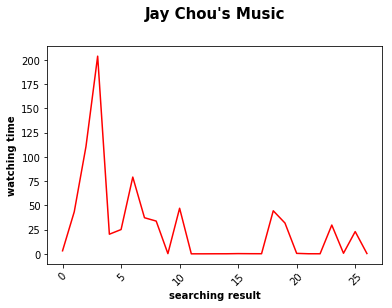

In [17]:
plt.plot(data1['觀看次數'], c = 'r')


plt.xlabel("searching result", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("Jay Chou's Music", fontsize = 15, fontweight = "bold", y = 1.1)
plt.xticks(rotation=45) 

7. 畫圖觀察發布天數與時間長短的關係

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 8 Text xticklabel objects>)

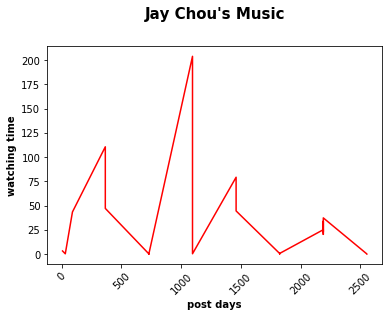

In [18]:
plt.plot(data['發布天數'], data['觀看次數'], c = 'r')


plt.xlabel("post days", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("Jay Chou's Music", fontsize = 15, fontweight = "bold", y = 1.1)
plt.xticks(rotation=45) 

### 杰倫的點閱率以百萬來計
1. 基本上杰倫現在只要現在發歌基本上就是必破百萬啦，現在的點閱率比以前暢銷曲高很多，猜想是因為近期有些影片是幕後花絮跟演唱會特輯，相對新歌來看比較觀眾沒有興趣 ，觀眾對於杰倫的新歌會感到好奇
2. 第一張圖是以搜尋熱度來排序
3. 第二張圖是以發布天數來排序

## 來看看我大杰倫在搜尋紀錄第一頁的觀看次數冠軍

### 告白氣球穩坐龍頭，觀看次數已達兩億次

In [19]:
data1.index = Series(titleD)
data2 = data1.sort_index(by = '觀看次數', ascending=False)
print(data2)

                                              發布天數        觀看次數
告白氣球 L                                        1095  203.819309
等你下課 Waiting For You】歌詞版                       365  110.537071
聽見下雨的聲音 Rhythm of the R                       1460   79.154326
不愛我就拉倒 If You Don't Love Me, It's F            365   47.012586
手寫的從前 Handwritten P                           1460   44.409641
說好不哭 Won'                                       90   43.367965
給我一首歌的時間 Give me the time of a song           2190   37.230398
說好的幸福呢 The Promised L                         2190   33.791920
晴天 Sunny D                                    2190   31.790814
夜曲 Y                                          2190   29.697465
擱淺 官方完整                                       2190   25.064046
髮如雪 Hair Lik                                  2190   22.968156
不能說的祕密 S                                      2190   20.246260
我是如此相信 I Truly B                                 7    3.141045
四季列車 Four Seasons T                           1825    0

D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


## 接下來我想要爬各個專輯的觀看次數

### 橫空出世，「JAY」周杰倫同名專輯

#### 一樣先去杰威爾替各張專輯找好的網頁裡觀察資料

In [64]:
url1 = "https://www.youtube.com/playlist?list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E"
request1 = requests.get(url1)
content1 = request1.content

soup1 = BeautifulSoup(content1, "html.parser")

#print(soup1)

#### 麻煩的在於，播放清單裡並不會顯示觀看次數，所以要先用迴圈把一個一個網址抓出來開，開啟了之後再去處理資料
1. 先試試看抓不抓得到單一網址
2. 抓到了之後再試著用迴圈把每一個網址爬出來

In [21]:
soup1.find('a',{'class':'pl-video-title-link'}).get('href')

'/watch?v=87VUC4J_0Ps&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=2&t=0s'

In [22]:
for all_mv in soup1.find_all('a',{'class':'pl-video-title-link'}):
    print("https://www.youtube.com{}".format(all_mv['href']))


https://www.youtube.com/watch?v=87VUC4J_0Ps&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=2&t=0s
https://www.youtube.com/watch?v=sTNJsIcPSvE&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=3&t=0s
https://www.youtube.com/watch?v=wRT-5heURhY&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=4&t=0s
https://www.youtube.com/watch?v=RPWDeLqsN0g&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=5&t=0s
https://www.youtube.com/watch?v=fuM1aVCGR8c&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=6&t=0s
https://www.youtube.com/watch?v=MpP9dw_j2PI&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=7&t=0s
https://www.youtube.com/watch?v=s9wvjSkR_Ms&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=8&t=0s
https://www.youtube.com/watch?v=gxZHH8x2zPg&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=9&t=0s
https://www.youtube.com/watch?v=npiAxeLtHDM&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=10&t=0s
https://www.youtube.com/watch?v=hnmWCmR6o7A&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=11&t=0s


3. 再開一個來觀察網頁html

In [63]:
url2 = "https://www.youtube.com/watch?v=87VUC4J_0Ps&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=2&t=0s"
request2 = requests.get(url2)
content2 = request2.content

soup2 = BeautifulSoup(content2, "html.parser")

#print(soup2)

4. 用ctrl+F迅速找到正確的觀看次數(要注意裡面很多觀看次數是推薦影片的，正確的觀看次數會顯示精確數字)，然後取出

In [24]:
soup2.find('div',{'class':'watch-view-count'}).get_text()

'觀看次數：9,222,616次'

5. 當然還是要來整理一下，我們把數值取出即可~

In [25]:
dwatch = soup2.find('div',{'class':'watch-view-count'}).get_text().strip('觀看次數：').strip('次').replace(',', '')
dwatch = int(dwatch)
print(dwatch)

9222616


6. 實在是懶得十個歌名都打，先試一個看看，就全部都爬起來!!!然後好好整理

In [26]:
soup2.find('span',{'class':'watch-title'}).get_text()

'\n    周杰倫【可愛女人 官方完整MV】Jay Chou "Adorable Lady" MV (feat.徐若瑄Vivian) (Ke-Ai-Nu-Ren)\n  '

7. 一切檢查完畢後來架迴圈，會花一點時間，因為要開子網頁去跑

In [27]:
url1 = "https://www.youtube.com/playlist?list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E"
request1 = requests.get(url1)
content1 = request1.content

soup1 = BeautifulSoup(content1, "html.parser")

ddwatch = []
title = []

for all_mv in soup1.find_all('a',{'class':'pl-video-title-link'}):
    url2 = "https://www.youtube.com{}".format(all_mv['href'])
    print(url2)
    request2 = requests.get(url2)
    content2 = request2.content

    soup2 = BeautifulSoup(content2, "html.parser")
    
    dwatch = soup2.find('div',{'class':'watch-view-count'}).get_text().strip('觀看次數：').strip('次').replace(',', '')
    dwatch = int(dwatch)
    print(dwatch)
    ddwatch.append(dwatch)
    
    ti = soup2.find('span',{'class':'watch-title'}).get_text()
    ti = ti.strip('\n').strip(' MV (feat.徐若瑄Vivian) (Ke-Ai-Nu-Ren)\n    ').strip('周杰倫').strip('Jay Chou 周杰倫').strip('Jay Chou "Adorable Lady" ').strip('Jay Chou "Adorable Lady" ').strip('-Official Music Vide').strip('Jay Chou "Tornado" MV (Long-Juan-Feng').strip('Jay Chou "Istanbul" MV (Yi-Si-Tan-B')
    title.append(ti)
    print(ti)

https://www.youtube.com/watch?v=87VUC4J_0Ps&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=2&t=0s
9222616
【可愛女人 官方完整MV】
https://www.youtube.com/watch?v=sTNJsIcPSvE&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=3&t=0s
8652115
【星晴 Starry Mood】
https://www.youtube.com/watch?v=wRT-5heURhY&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=4&t=0s
7556490
【黑色幽默 Black Humor】
https://www.youtube.com/watch?v=RPWDeLqsN0g&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=5&t=0s
16418429
【龍捲風 官方完整MV】
https://www.youtube.com/watch?v=fuM1aVCGR8c&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=6&t=0s
3100061
【反方向的鐘 Counter-clockwise Clock】
https://www.youtube.com/watch?v=MpP9dw_j2PI&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=7&t=0s
2197748
【娘子 Wife】
https://www.youtube.com/watch?v=s9wvjSkR_Ms&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=8&t=0s
1892512
【伊斯坦堡 官方完整MV】
https://www.youtube.com/watch?v=gxZHH8x2zPg&list=PLgFC_SXvt6LnCgyvAFpi4s_bR9x-yXv3E&index=9&t=0s
2118185
【完美主義 Perfectionism】
https://www.youtube

In [28]:
ddwatch

[9222616,
 8652115,
 7556490,
 16418429,
 3100061,
 2197748,
 1892512,
 2118185,
 1706583,
 1769529]

In [29]:
title

['【可愛女人 官方完整MV】',
 '【星晴 Starry Mood】',
 '【黑色幽默 Black Humor】',
 '【龍捲風 官方完整MV】',
 '【反方向的鐘 Counter-clockwise Clock】',
 '【娘子 Wife】',
 '【伊斯坦堡 官方完整MV】',
 '【完美主義 Perfectionism】',
 '【鬥牛 Basketball Match】',
 '【印地安老斑鳩 Ancient Indian Turtledove】']

8. 做成DataFrame，歌名太長了，在跑完圖表之前，先用歌曲編號排序

In [30]:
Jay = DataFrame(ddwatch)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Jay.index = Series(song)
Jay.rename( columns={0:'觀看次數'},inplace=True)
Jay1 = Jay
print(Jay)

        觀看次數
1    9222616
2    8652115
3    7556490
4   16418429
5    3100061
6    2197748
7    1892512
8    2118185
9    1706583
10   1769529


9. 跑完圖表發現Jay這張專輯第四首歌觀看次數超級多

Text(0.5,1.1,'Jay')

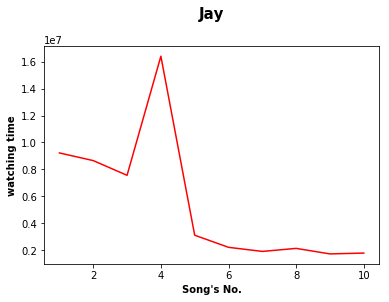

In [31]:

plt.plot(Jay, c = 'r')
plt.xlabel("Song's No.", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("Jay", fontsize = 15, fontweight = "bold", y = 1.1)

10. 再用觀看次數去降序，這張專輯最熱門的歌是龍捲風

In [32]:
Jay['歌名'] = title
Jay.reindex(columns = ['歌名', '觀看次數'])

,歌名,觀看次數
1,【可愛女人 官方完整MV】,9222616
2,【星晴 Starry Mood】,8652115
3,【黑色幽默 Black Humor】,7556490
4,【龍捲風 官方完整MV】,16418429
5,【反方向的鐘 Counter-clockwise Clock】,3100061
6,【娘子 Wife】,2197748
7,【伊斯坦堡 官方完整MV】,1892512
8,【完美主義 Perfectionism】,2118185
9,【鬥牛 Basketball Match】,1706583
10,【印地安老斑鳩 Ancient Indian Turtledove】,1769529


In [33]:


print('---------------------------------------------------------------------------------------')

JayS = Jay.sort_index(by = '觀看次數', ascending=False)
JayS

---------------------------------------------------------------------------------------


D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """


,觀看次數,歌名
4,16418429,【龍捲風 官方完整MV】
1,9222616,【可愛女人 官方完整MV】
2,8652115,【星晴 Starry Mood】
3,7556490,【黑色幽默 Black Humor】
5,3100061,【反方向的鐘 Counter-clockwise Clock】
6,2197748,【娘子 Wife】
8,2118185,【完美主義 Perfectionism】
7,1892512,【伊斯坦堡 官方完整MV】
10,1769529,【印地安老斑鳩 Ancient Indian Turtledove】
9,1706583,【鬥牛 Basketball Match】


### 第二張專輯，神到不行的「范特西」
#### 重複上一張專輯的步驟就行了

In [34]:
url1 = "https://www.youtube.com/playlist?list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj"
request1 = requests.get(url1)
content1 = request1.content

soup1 = BeautifulSoup(content1, "html.parser")

ddwatch = []
title = []

for all_mv in soup1.find_all('a',{'class':'pl-video-title-link'}):
    url2 = "https://www.youtube.com{}".format(all_mv['href'])
    print(url2)
    request2 = requests.get(url2)
    content2 = request2.content

    soup2 = BeautifulSoup(content2, "html.parser")
    
    dwatch = soup2.find('div',{'class':'watch-view-count'}).get_text().strip('觀看次數：').strip('次').replace(',', '')
    dwatch = int(dwatch)
    print(dwatch)
    ddwatch.append(dwatch)

    ti = soup2.find('span',{'class':'watch-title'}).get_text()
    ti = ti.strip('\n').strip('周杰倫 Jay Chou').strip('Official MV\n')
    title.append(ti)
    print(ti)
    
Fantacy = DataFrame(ddwatch)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Fantacy.index = Series(song)
Fantacy.rename( columns={0:'觀看次數'},inplace=True)
Fantacy1 = Fantacy
print(Fantacy)

https://www.youtube.com/watch?v=CcfnZOJpbM4&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=2&t=0s
4953808
【上海 一九四三 Shanghai 1943】
https://www.youtube.com/watch?v=55yJh4SHUBY&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=3&t=0s
2587015
【忍者 Ninja】
https://www.youtube.com/watch?v=nhyT8HDT4lg&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=4&t=0s
2277447
【爸 我回來了 Dad, I'm home】
https://www.youtube.com/watch?v=lCzWCxVAkfc&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=5&t=0s
2453198
【威廉古堡 William Castle】
https://www.youtube.com/watch?v=H7hpK6cm-6k&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=6&t=0s
20555844
【開不了口 I Find It Hard To Say】
https://www.youtube.com/watch?v=5XK2C9w6oVk&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=7&t=0s
10047090
【愛在西元前 Love before BC】
https://www.youtube.com/watch?v=N2DkKFxijv0&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=8&t=0s
2270381
【對不起 Sorry】
https://www.youtube.com/watch?v=OR-0wptI_u0&list=PLgFC_SXvt6LkYvsRdMGQunFCL4OE8CTFj&index=9&t=0s
4628710
【雙截棍 Nunchucks

Text(0.5,1.1,'Fantacy')

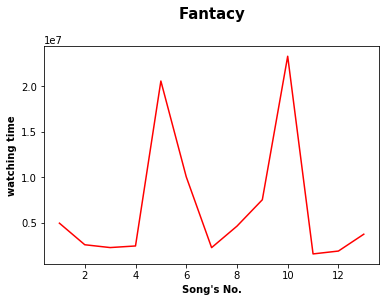

In [35]:
plt.plot(Fantacy, c = 'r')
plt.xlabel("Song's No.", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("Fantacy", fontsize = 15, fontweight = "bold", y = 1.1)

In [36]:
Fantacy['歌名'] = title
Fantacy.reindex(columns = ['歌名', '觀看次數'])
Fantacy

,觀看次數,歌名
1,4953808,【上海 一九四三 Shanghai 1943】
2,2587015,【忍者 Ninja】
3,2277447,"【爸 我回來了 Dad, I'm home】"
4,2453198,【威廉古堡 William Castle】
5,20555844,【開不了口 I Find It Hard To Say】
6,10047090,【愛在西元前 Love before BC】
7,2270381,【對不起 Sorry】
8,4628710,【雙截棍 Nunchucks】
9,7525473,【簡單愛 Simple Love】
10,23276412,【安靜 Silence】


In [37]:

print('---------------------------------------------------------------------------------------')

FantacyS = Fantacy.sort_index(by = '觀看次數', ascending=False)
FantacyS

---------------------------------------------------------------------------------------


D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


,觀看次數,歌名
10,23276412,【安靜 Silence】
5,20555844,【開不了口 I Find It Hard To Say】
6,10047090,【愛在西元前 Love before BC】
9,7525473,【簡單愛 Simple Love】
1,4953808,【上海 一九四三 Shanghai 1943】
8,4628710,【雙截棍 Nunchucks】
13,3743537,【世界末日 End of the World】
2,2587015,【忍者 Ninja】
4,2453198,【威廉古堡 William Castle】
3,2277447,"【爸 我回來了 Dad, I'm home】"


### 第三張專輯，想像不到的「八度空間」

In [38]:
url1 = "https://www.youtube.com/playlist?list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom"
request1 = requests.get(url1)
content1 = request1.content

soup1 = BeautifulSoup(content1, "html.parser")

ddwatch = []
title = []

for all_mv in soup1.find_all('a',{'class':'pl-video-title-link'}):
    url2 = "https://www.youtube.com{}".format(all_mv['href'])
    print(url2)
    request2 = requests.get(url2)
    content2 = request2.content

    soup2 = BeautifulSoup(content2, "html.parser")
    
    dwatch = soup2.find('div',{'class':'watch-view-count'}).get_text().strip('觀看次數：').strip('次').replace(',', '')
    dwatch = int(dwatch)
    print(dwatch)
    ddwatch.append(dwatch)
    
    ti = soup2.find('span',{'class':'watch-title'}).get_text()
    ti = ti.strip('\n').strip('周杰倫 Jay Chou').strip('Official MV\n')
    title.append(ti)
    print(ti)
    

space = DataFrame(ddwatch)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
space.index = Series(song)
space.rename( columns={0:'觀看次數'},inplace=True)

space1 = space
print(space)

https://www.youtube.com/watch?v=eM6mF4RWhe0&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=2&t=0s
4272933
【分裂 Split】
https://www.youtube.com/watch?v=K5qKpFLWaoA&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=3&t=0s
1331994
【火車叨位去 The Train's Destination】
https://www.youtube.com/watch?v=duZDsG3tvoA&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=4&t=0s
10628589
【半島鐵盒 Peninsula Ironbox】
https://www.youtube.com/watch?v=MKNrnSsIwf8&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=5&t=0s
10004515
【回到過去 Back to the Past】
https://www.youtube.com/watch?v=CYT9DPJdtS4&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=6&t=0s
5930679
【暗號 Secret Sign】
https://www.youtube.com/watch?v=KmaqqnLGUG0&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=7&t=0s
1852973
【米蘭小鐵匠 Little Blacksmith in Milan】
https://www.youtube.com/watch?v=LdPjnubLRN0&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=8&t=0s
4252988
【爺爺泡的茶 Grandpa's Tea】
https://www.youtube.com/watch?v=3I27c6t-0No&list=PLgFC_SXvt6Lmkks32yM_6l-Eb6KMdgBom&index=9&t=0s


Text(0.5,1.1,'EIGHT DIMENSION')

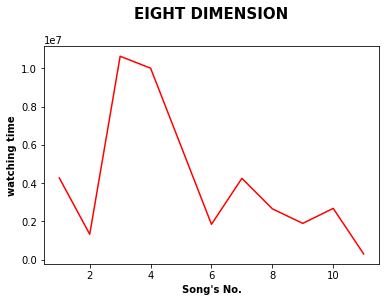

In [39]:
plt.plot(space, c = 'r')
plt.xlabel("Song's No.", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("EIGHT DIMENSION", fontsize = 15, fontweight = "bold", y = 1.1)

In [40]:
space['歌名'] = title
space.reindex(columns = ['歌名', '觀看次數'])
space

,觀看次數,歌名
1,4272933,【分裂 Split】
2,1331994,【火車叨位去 The Train's Destination】
3,10628589,【半島鐵盒 Peninsula Ironbox】
4,10004515,【回到過去 Back to the Past】
5,5930679,【暗號 Secret Sign】
6,1852973,【米蘭小鐵匠 Little Blacksmith in Milan】
7,4252988,【爺爺泡的茶 Grandpa's Tea】
8,2660387,【半獸人 Half-beast Human】
9,1900504,【龍拳 Dragon Fist】
10,2683986,【最後的戰役 The Final Battle】


In [41]:


print('---------------------------------------------------------------------------------------')

spaceS = space.sort_index(by = '觀看次數', ascending=False)
spaceS

---------------------------------------------------------------------------------------


D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """


,觀看次數,歌名
3,10628589,【半島鐵盒 Peninsula Ironbox】
4,10004515,【回到過去 Back to the Past】
5,5930679,【暗號 Secret Sign】
1,4272933,【分裂 Split】
7,4252988,【爺爺泡的茶 Grandpa's Tea】
10,2683986,【最後的戰役 The Final Battle】
8,2660387,【半獸人 Half-beast Human】
9,1900504,【龍拳 Dragon Fist】
6,1852973,【米蘭小鐵匠 Little Blacksmith in Milan】
2,1331994,【火車叨位去 The Train's Destination】


### 第四張專輯，以母為名的「葉惠美」

In [42]:
url1 = "https://www.youtube.com/playlist?list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg"
request1 = requests.get(url1)
content1 = request1.content

soup1 = BeautifulSoup(content1, "html.parser")

ddwatch = []
title = []

for all_mv in soup1.find_all('a',{'class':'pl-video-title-link'}):
    url2 = "https://www.youtube.com{}".format(all_mv['href'])
    print(url2)
    request2 = requests.get(url2)
    content2 = request2.content

    soup2 = BeautifulSoup(content2, "html.parser")
    
    dwatch = soup2.find('div',{'class':'watch-view-count'}).get_text().strip('觀看次數：').strip('次').replace(',', '')
    dwatch = int(dwatch)
    print(dwatch)
    ddwatch.append(dwatch)
    
    ti = soup2.find('span',{'class':'watch-title'}).get_text()
    ti = ti.strip('\n').strip('周杰倫 Jay Chou').strip('Official MV\n').strip('周杰倫 Jay Chou').strip('-Official Music Video\n').strip('-Official Movie Version\n')
    ti = ti.strip('Jay Chou "Cliff" MV (Ai-Qing-Xuan-Ya)').strip('Jay Chou "Double Blade" MV (Shuang-Dao)').strip('Jay Chou "You Hear Me" MV (Ni-Ti').strip('Jay Chou "In The Name of Father" MV (Yi-Fu-Z')
    title.append(ti)
    print(ti)
    

YHM = DataFrame(ddwatch)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
YHM.index = Series(song)
YHM.rename( columns={0:'觀看次數'},inplace=True)

YHM1 = YHM
print(YHM)

https://www.youtube.com/watch?v=DYptgVvkVLQ&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=2&t=0s
31790987
【晴天 Sunny Day】
https://www.youtube.com/watch?v=qct0JLjaHDc&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=3&t=0s
7688483
【東風破 Dong-Feng-Po】
https://www.youtube.com/watch?v=gqzlB7Gla2E&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=4&t=0s
2775977
【她的睫毛 Her Eyelashes】
https://www.youtube.com/watch?v=_trE3M24kQY&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=5&t=0s
3585450
【三年二班 Class 3-2】
https://www.youtube.com/watch?v=Xi_RBDWZaT0&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=6&t=0s
1102144
【懦夫 Coward】
https://www.youtube.com/watch?v=WM7K9mnLWzw&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=7&t=0s
203698
【雙刀電影版 Double Blade】
https://www.youtube.com/watch?v=T4qPsRLjGCY&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=8&t=0s
958052
【雙刀 官方完整MV】
https://www.youtube.com/watch?v=H5VQdhYh9rc&list=PLgFC_SXvt6LmByjzSBtO1aD1W9J5D3ppg&index=9&t=0s
2071255
【愛情懸崖 官方完整MV】
https://www.youtube.com/watch?

Text(0.5,1.1,'YEH HUI MEI')

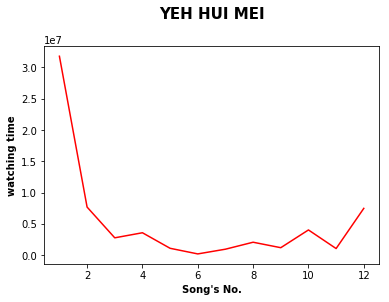

In [43]:
plt.plot(YHM, c = 'r')
plt.xlabel("Song's No.", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("YEH HUI MEI", fontsize = 15, fontweight = "bold", y = 1.1)

In [44]:
YHM['歌名'] = title
YHM.reindex(columns = ['歌名', '觀看次數'])
YHM

,觀看次數,歌名
1,31790987,【晴天 Sunny Day】
2,7688483,【東風破 Dong-Feng-Po】
3,2775977,【她的睫毛 Her Eyelashes】
4,3585450,【三年二班 Class 3-2】
5,1102144,【懦夫 Coward】
6,203698,【雙刀電影版 Double Blade】
7,958052,【雙刀 官方完整MV】
8,2071255,【愛情懸崖 官方完整MV】
9,1197810,【梯田 Terrace Field】
10,4033691,【妳聽得到 官方完整MV】


In [45]:

print('---------------------------------------------------------------------------------------')

YHMS = YHM.sort_index(by = '觀看次數', ascending=False)
YHMS

---------------------------------------------------------------------------------------


D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


,觀看次數,歌名
1,31790987,【晴天 Sunny Day】
2,7688483,【東風破 Dong-Feng-Po】
12,7481530,【以父之名 官方完整MV】
10,4033691,【妳聽得到 官方完整MV】
4,3585450,【三年二班 Class 3-2】
3,2775977,【她的睫毛 Her Eyelashes】
8,2071255,【愛情懸崖 官方完整MV】
9,1197810,【梯田 Terrace Field】
5,1102144,【懦夫 Coward】
11,1062372,【同一種調調 Same Tone】


### 第五張專輯，綻放的「七里香」

In [46]:
url1 = "https://www.youtube.com/playlist?list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr"
request1 = requests.get(url1)
content1 = request1.content

soup1 = BeautifulSoup(content1, "html.parser")

ddwatch = []
title = []

for all_mv in soup1.find_all('a',{'class':'pl-video-title-link'}):
    url2 = "https://www.youtube.com{}".format(all_mv['href'])
    print(url2)
    request2 = requests.get(url2)
    content2 = request2.content

    soup2 = BeautifulSoup(content2, "html.parser")
    
    dwatch = soup2.find('div',{'class':'watch-view-count'}).get_text().strip('觀看次數：').strip('次').replace(',', '')
    dwatch = int(dwatch)
    print(dwatch)
    ddwatch.append(dwatch)
    
    ti = soup2.find('span',{'class':'watch-title'}).get_text()
    ti = ti.strip('\n').strip('周杰倫 Jay Chou').strip('-Official Music Video\n').strip('-Official Movie Version\n')
    ti = ti.strip('Jay Chou "Step Aside" MV (Ge-Qian)').strip('Jay Chou "Struggle" MV (Kun-Shou-Zhi-Dou)').strip('Jay Chou "General" MV (Jiang-Jun)')
    title.append(ti)
    print(ti)

jasmine = DataFrame(ddwatch)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
jasmine.index = Series(song)
jasmine.rename( columns={0:'觀看次數'},inplace=True)


jasmine1 = jasmine
print(jasmine)

https://www.youtube.com/watch?v=Bbp9ZaJD_eA&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=2&t=0s
25887386
【七里香 Qi-Li-Xiang】
https://www.youtube.com/watch?v=IoCoIxkGkVw&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=3&t=0s
5041772
【園遊會 Fun Fair】
https://www.youtube.com/watch?v=YJfHuATJYsQ&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=4&t=0s
25064139
【擱淺 官方完整MV】
https://www.youtube.com/watch?v=KcK8WurGpEQ&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=5&t=0s
19546140
【藉口 Excuse】
https://www.youtube.com/watch?v=pm91leB_P8c&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=6&t=0s
1523794
【困獸之鬥 官方完整MV】
https://www.youtube.com/watch?v=2Tg3uzSAkXk&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=7&t=0s
1881939
【亂舞春秋 Chaotic Dance】
https://www.youtube.com/watch?v=Ur-x4pZT1Rk&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=8&t=0s
3975242
【外婆 Grandma】
https://www.youtube.com/watch?v=RJerfq6MqY0&list=PLgFC_SXvt6LlDj8gGoHRhU0AtVxHpNknr&index=9&t=0s
1559805
【我的地盤 My Territory】
https://www.youtube.com/watch?v=

Text(0.5,1.1,'JASMINE')

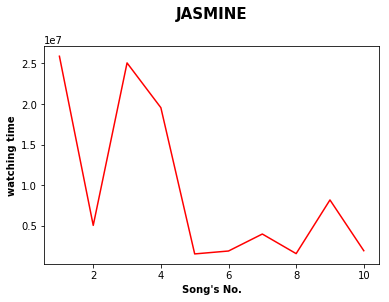

In [47]:
plt.plot(jasmine, c = 'r')
plt.xlabel("Song's No.", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("JASMINE", fontsize = 15, fontweight = "bold", y = 1.1)

In [48]:
jasmine['歌名'] = title
jasmine.reindex(columns = ['歌名', '觀看次數'])
jasmine

,觀看次數,歌名
1,25887386,【七里香 Qi-Li-Xiang】
2,5041772,【園遊會 Fun Fair】
3,25064139,【擱淺 官方完整MV】
4,19546140,【藉口 Excuse】
5,1523794,【困獸之鬥 官方完整MV】
6,1881939,【亂舞春秋 Chaotic Dance】
7,3975242,【外婆 Grandma】
8,1559805,【我的地盤 My Territory】
9,8175222,【止戰之殤 Wounds of War】
10,1919779,【將軍 官方完整MV】


In [49]:

print('---------------------------------------------------------------------------------------')

jasmineS = jasmine.sort_index(by = '觀看次數', ascending=False)
jasmineS

---------------------------------------------------------------------------------------


D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


,觀看次數,歌名
1,25887386,【七里香 Qi-Li-Xiang】
3,25064139,【擱淺 官方完整MV】
4,19546140,【藉口 Excuse】
9,8175222,【止戰之殤 Wounds of War】
2,5041772,【園遊會 Fun Fair】
7,3975242,【外婆 Grandma】
10,1919779,【將軍 官方完整MV】
6,1881939,【亂舞春秋 Chaotic Dance】
8,1559805,【我的地盤 My Territory】
5,1523794,【困獸之鬥 官方完整MV】


### 第六張專輯，躍然琴鍵間的「十一月的蕭邦」

In [51]:
url1 = "https://www.youtube.com/playlist?list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S"
request1 = requests.get(url1)
content1 = request1.content

soup1 = BeautifulSoup(content1, "html.parser")

ddwatch = []
title = []

for all_mv in soup1.find_all('a',{'class':'pl-video-title-link'}):
    url2 = "https://www.youtube.com{}".format(all_mv['href'])
    print(url2)
    request2 = requests.get(url2)
    content2 = request2.content

    soup2 = BeautifulSoup(content2, "html.parser")
    
    dwatch = soup2.find('div',{'class':'watch-view-count'}).get_text().strip('觀看次數：').strip('次').replace(',', '')
    dwatch = int(dwatch)
    print(dwatch)
    ddwatch.append(dwatch)
    
    ti = soup2.find('span',{'class':'watch-title'}).get_text()
    ti = ti.strip('\n').strip('周杰倫 Jay Chou').strip('-Official Music Video\n').strip('-Official Movie Version\n')
    ti = ti.strip('Jay Chou "Against" MV (Ni-Lin)').strip('(頭文字Dの実写版')
    title.append(ti)
    print(ti)

chopin = DataFrame(ddwatch)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
chopin.index = Series(song)
chopin.rename( columns={0:'觀看次數'},inplace=True)

chopin1 = chopin
print(chopin)

https://www.youtube.com/watch?v=6Q0Pd53mojY&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=2&t=0s
29698034
【夜曲 Ye Qu】
https://www.youtube.com/watch?v=kYhh1PpsOg4&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=3&t=0s
14826349
【珊瑚海 Coral Sea】
https://www.youtube.com/watch?v=aaM7qG2ycjk&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=4&t=0s
22968329
【髮如雪 Hair Like Snow】
https://www.youtube.com/watch?v=X2njc8is50o&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=5&t=0s
5278725
【飄移 Drifting】
https://www.youtube.com/watch?v=bX33UI9ZPLk&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=6&t=0s
10260079
【黑色毛衣 Black Sweater】
https://www.youtube.com/watch?v=P7ItYKdY0WU&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=7&t=0s
2103669
【藍色風暴 Blue Storm】
https://www.youtube.com/watch?v=qzwsQTY-99o&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=8&t=0s
23237527
【楓Maple Leaf 】
https://www.youtube.com/watch?v=Hq47d-ouX_Y&list=PLgFC_SXvt6LnaeH6Z9wJ8MDQnUKIr5m2S&index=9&t=0s
1873895
【麥芽糖 Malt Sugar】
https://www.youtube.co

Text(0.5,1.1,"NOVEMBER'S CHOPIN")

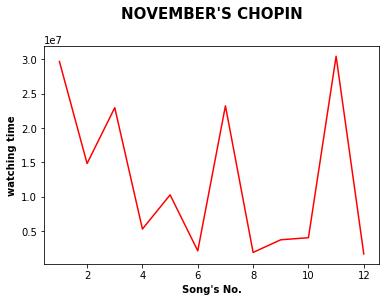

In [52]:
plt.plot(chopin, c = 'r')
plt.xlabel("Song's No.", fontweight = "bold")
plt.ylabel("watching time", fontweight = "bold") 
plt.title("NOVEMBER'S CHOPIN", fontsize = 15, fontweight = "bold", y = 1.1)

In [53]:
chopin['歌名'] = title
chopin.reindex(columns = ['歌名', '觀看次數'])
chopin

,觀看次數,歌名
1,29698034,【夜曲 Ye Qu】
2,14826349,【珊瑚海 Coral Sea】
3,22968329,【髮如雪 Hair Like Snow】
4,5278725,【飄移 Drifting】
5,10260079,【黑色毛衣 Black Sweater】
6,2103669,【藍色風暴 Blue Storm】
7,23237527,【楓Maple Leaf 】
8,1873895,【麥芽糖 Malt Sugar】
9,3712738,【浪漫手機 Romantic Cellphone】
10,4018150,【四面楚歌 Surrounded】


In [54]:

print('---------------------------------------------------------------------------------------')

chopinS = chopin.sort_index(by = '觀看次數', ascending=False)
chopinS

---------------------------------------------------------------------------------------


D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


,觀看次數,歌名
11,30464693,【一路向北 All the Way North】
1,29698034,【夜曲 Ye Qu】
7,23237527,【楓Maple Leaf 】
3,22968329,【髮如雪 Hair Like Snow】
2,14826349,【珊瑚海 Coral Sea】
5,10260079,【黑色毛衣 Black Sweater】
4,5278725,【飄移 Drifting】
10,4018150,【四面楚歌 Surrounded】
9,3712738,【浪漫手機 Romantic Cellphone】
6,2103669,【藍色風暴 Blue Storm】


## 最後把六張專輯的資料合併

In [55]:
alkl = pd.concat([Jay,Fantacy,space, YHM, jasmine, chopin])

alkl = alkl.reindex(columns = ['歌名', '觀看次數'])

In [56]:
num = range(1, 69)
alkl.index = Series(list(num))
alkl

,歌名,觀看次數
1,【可愛女人 官方完整MV】,9222616
2,【星晴 Starry Mood】,8652115
3,【黑色幽默 Black Humor】,7556490
4,【龍捲風 官方完整MV】,16418429
5,【反方向的鐘 Counter-clockwise Clock】,3100061
6,【娘子 Wife】,2197748
7,【伊斯坦堡 官方完整MV】,1892512
8,【完美主義 Perfectionism】,2118185
9,【鬥牛 Basketball Match】,1706583
10,【印地安老斑鳩 Ancient Indian Turtledove】,1769529


### 畫成折線圖

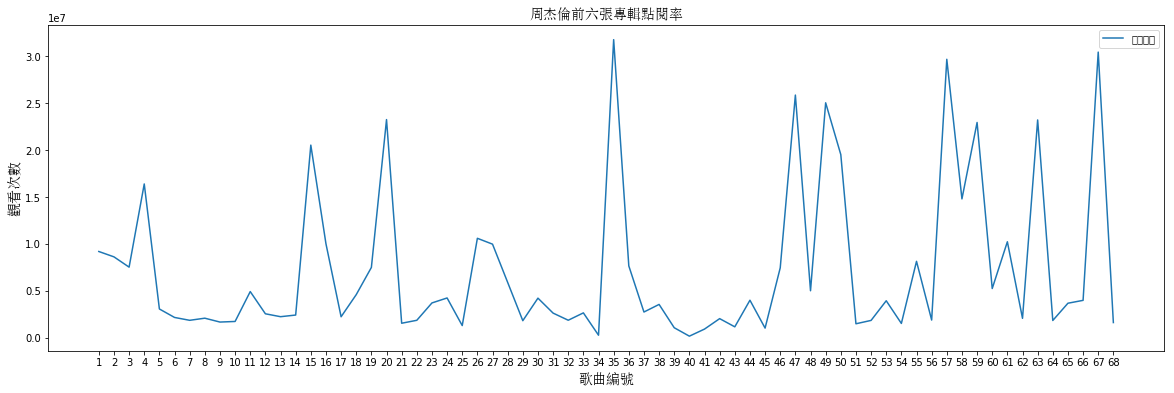

In [57]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
alkl.plot(xticks = range(1, 69), figsize=(20, 6))
plt.xlabel("歌曲編號", fontproperties=font)
plt.ylabel("觀看次數", fontproperties=font)
plt.title("周杰倫前六張專輯點閱率", fontproperties=font)
plt.show()

### 用觀看次數排序(這裡只取前20)

* 發現杰倫在第六張專輯「十一月的蕭邦」獲得較多點閱率(我最喜歡的專輯，顆顆)

In [58]:
als = alkl.sort_index(by = '觀看次數', ascending=False)
als[:20]

D:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,歌名,觀看次數
35,【晴天 Sunny Day】,31790987
67,【一路向北 All the Way North】,30464693
57,【夜曲 Ye Qu】,29698034
47,【七里香 Qi-Li-Xiang】,25887386
49,【擱淺 官方完整MV】,25064139
20,【安靜 Silence】,23276412
63,【楓Maple Leaf 】,23237527
59,【髮如雪 Hair Like Snow】,22968329
15,【開不了口 I Find It Hard To Say】,20555844
50,【藉口 Excuse】,19546140


## 六張專輯的總觀看次數

In [59]:
sum = als['觀看次數'].sum()
print("總觀看次數：{}次".format(sum))

總觀看次數：496875937次


## 把六張專輯六張圖合併就大功告成，讚讚

Text(0.5,1.1,"NOVEMBER'S CHOPIN")

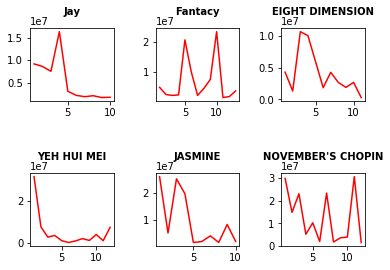

In [60]:
plt.subplots_adjust(wspace = 0.5, hspace = 1)
plt.tight_layout()

plt.subplot(2, 3, 1)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Jay1.index = Series(song)
Jay1.drop(['歌名'], axis=1, inplace=True)
plt.plot(Jay1, c = 'r')
plt.title("Jay", fontsize = 10, fontweight = "bold", y = 1.1)

plt.subplot(2, 3, 2)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Fantacy1.index = Series(song)
Fantacy1.drop(['歌名'], axis=1, inplace=True)
plt.plot(Fantacy1, c = 'r')
plt.title("Fantacy", fontsize = 10, fontweight = "bold", y = 1.1)

plt.subplot(2, 3, 3)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
space1.index = Series(song)
space1.drop(['歌名'], axis=1, inplace=True)
plt.plot(space1, c = 'r')
plt.title("EIGHT DIMENSION", fontsize = 10, fontweight = "bold", y = 1.1)

plt.subplot(2, 3, 4)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
YHM1.index = Series(song)
YHM1.drop(['歌名'], axis=1, inplace=True)
plt.plot(YHM1, c = 'r')
plt.title("YEH HUI MEI", fontsize = 10, fontweight = "bold", y = 1.1)

plt.subplot(2, 3, 5)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
jasmine1.index = Series(song)
jasmine1.drop(['歌名'], axis=1, inplace=True)
plt.plot(jasmine1, c = 'r')
plt.title("JASMINE", fontsize = 10, fontweight = "bold", y = 1.1)

plt.subplot(2, 3, 6)
song = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
chopin1.index = Series(song)
chopin1.drop(['歌名'], axis=1, inplace=True)
plt.plot(chopin1, c = 'r')
plt.title("NOVEMBER'S CHOPIN", fontsize = 10, fontweight = "bold", y = 1.1)
